In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

print("Random documents", len(r_index))

Random documents 733


In [3]:
from alterations import postfix_data

df = postfix_data(df)

In [4]:
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
all_classes = []
i = 0
broad_cats = []
for c in cats:
    bc = {"start":i,"name": c.name}
    for ec in c.equivalents.filter(level=4).exclude(name__icontains="<hidden>").order_by('name','level'):
        ecname = f"{ec.level} - {ec.name}"
        if ecname in df.columns and df[ecname].sum()>=5:
            all_classes.append(ecname)
            i+=1
    bc["end"] = i
    bc["size"] = i-bc["start"]
    broad_cats.append(bc)
            
print(len(all_classes))
broad_cats

50


[{'end': 9, 'name': 'Physical systems', 'size': 9, 'start': 0},
 {'end': 14, 'name': 'Mountains, snow and ice', 'size': 5, 'start': 9},
 {'end': 21,
  'name': 'Rivers, lakes, and soil moisture',
  'size': 7,
  'start': 14},
 {'end': 28, 'name': 'Coastal and marine Ecosystems', 'size': 7, 'start': 21},
 {'end': 37, 'name': 'Terrestrial ES', 'size': 9, 'start': 28},
 {'end': 50, 'name': 'Human and managed', 'size': 13, 'start': 37}]

12 - Physical systems
150
Physical systems
[{'name': '11 Storms'}, {'name': '08 Changes in strong precipitation'}, {'name': '11 Storms'}, {'name': '14 Sea level change'}, {'name': '18 Oxygen content'}, {'name': '19 Water quality/chemistry (oceans)'}, {'name': '17 Ocean acidification'}, {'name': '02 Air or land surface temperature changes'}, {'name': '01 CO2 concentration'}, {'name': '09 Atmospheric/marine circulation or teleconnections'}, {'name': '09 Atmospheric/marine circulation or teleconnections'}, {'name': '03 Extreme temperature'}, {'name': '10 Wind speed'}, {'name': '15 Coastal flooding'}, {'name': '05 Changes in precipitation'}, {'name': '05 Changes in precipitation'}, {'name': '16 Sea surface temperature'}, {'name': '07 Aridity/dryness'}, {'name': '19 Water quality/chemistry (oceans)'}, {'name': '08 Changes in strong precipitation'}, {'name': '07 Aridity/dryness'}, {'name': '14 Sea level change'}, {'name': '18 Oxygen content'}, {'name': '02 Air or land surface temperature cha

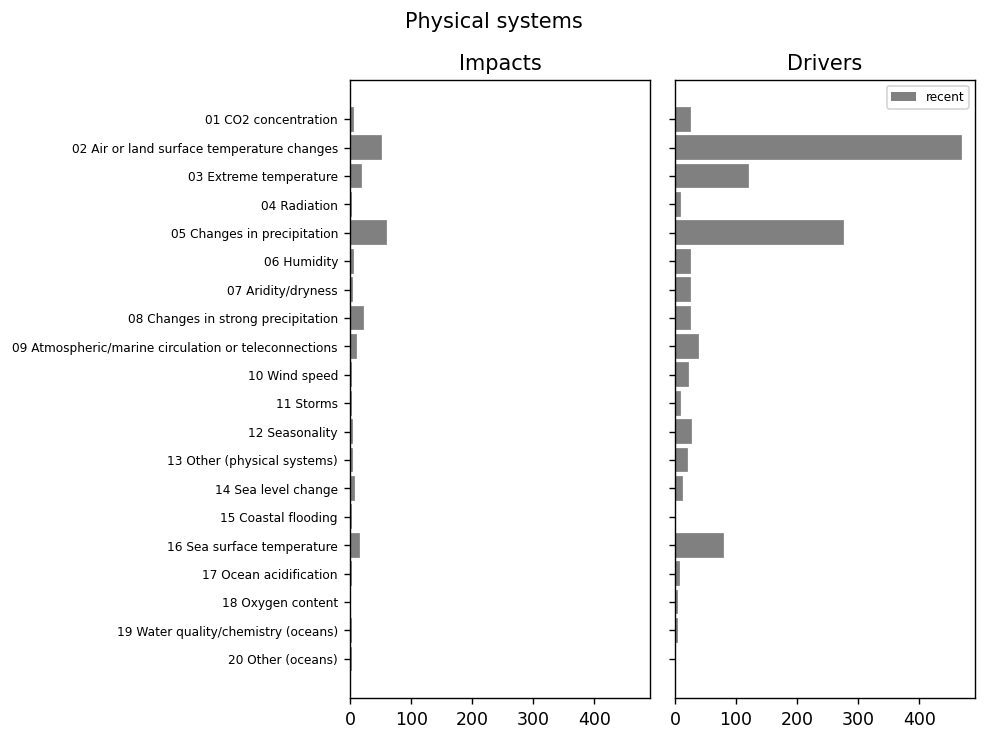

12 - Mountains, snow and ice
163.0
Mountains, snow and ice
[{'name': '31 Landslides/instability'}, {'name': '32 Permafrost'}, {'name': '32 Permafrost'}, {'name': '33 Sea ice retreat'}, {'name': '34 Glacier retreat'}, {'name': '34 Glacier retreat'}, {'name': '33 Sea ice retreat'}, {'name': '30 Snow'}, {'name': '30 Snow'}, {'name': '35 Other (mountains, snow and ice)'}, {'name': '31 Landslides/instability'}, {'name': '35 Other (mountains, snow and ice)'}]
163.0


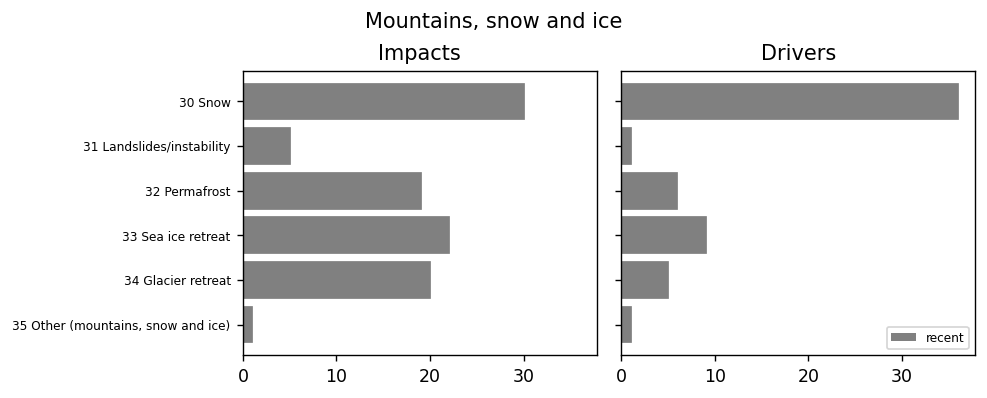

12 - Rivers, lakes, and soil moisture
303.0
Rivers, lakes, and soil moisture
[{'name': '21 Water temperature (freshwater)'}, {'name': '24 Water level (lake, reservoir, groundwater)'}, {'name': '26 Drought frequency and intensity'}, {'name': '26 Drought frequency and intensity'}, {'name': '22 Water quality/chemistry (freshwater)'}, {'name': '22 Water quality/chemistry (freshwater)'}, {'name': '21 Water temperature (freshwater)'}, {'name': '28 River runoff'}, {'name': '23 Soil moisture'}, {'name': '23 Soil moisture'}, {'name': '24 Water level (lake, reservoir, groundwater)'}, {'name': '25 Evapotranspiration'}, {'name': '25 Evapotranspiration'}, {'name': '27 River floods'}, {'name': '27 River floods'}, {'name': '28 River runoff'}, {'name': '29 Other (Rivers, lakes and soil moisture)'}, {'name': '29 Other (Rivers, lakes and soil moisture)'}]
303.0


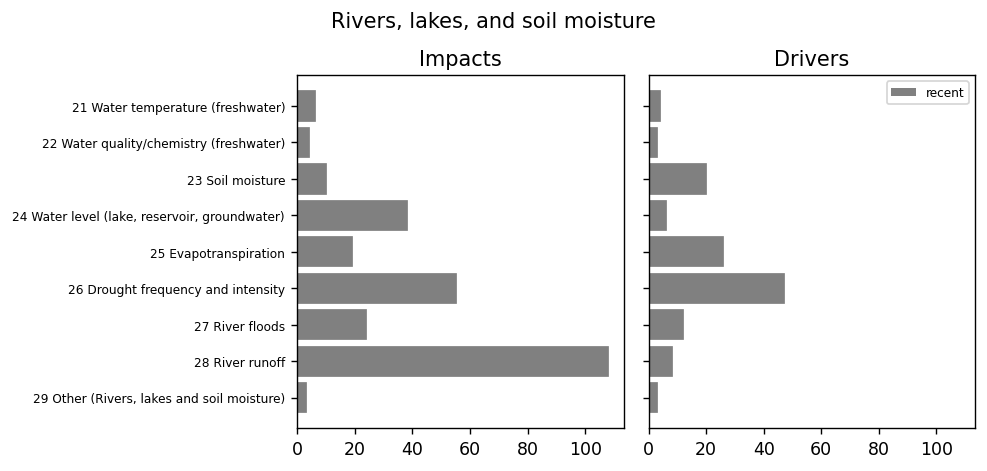

12 - Coastal and marine Ecosystems
185.0
Coastal and marine Ecosystems
[{'name': '42 Species abundance (marine & coastal)'}, {'name': '36 Species distribution (marine & coastal)'}, {'name': '43 Biome shift (marine & coastal)'}, {'name': '50 Other (marine & coastal)'}, {'name': '50 Other (marine & coastal)'}, {'name': '38 Geographical shift  (marine & coastal)'}, {'name': '41 Species metabolism (marine & coastal)'}, {'name': '41 Species metabolism (marine & coastal)'}, {'name': '49 Biogeochemical flows (marine & coastal)'}, {'name': '40 Changes in warm water corals'}, {'name': '48 Carbon cycle (marine & coastal)'}, {'name': '46 Changes in kelp forests'}, {'name': '44 Biodiversity effects (marine & coastal)'}, {'name': '37 Shifts in phenology (marine & coastal)'}, {'name': '42 Species abundance (marine & coastal)'}, {'name': '45 Ocean ecosystem productivity'}, {'name': '47 Seagrass'}, {'name': '43 Biome shift (marine & coastal)'}, {'name': '37 Shifts in phenology (marine & coastal)'}, {'

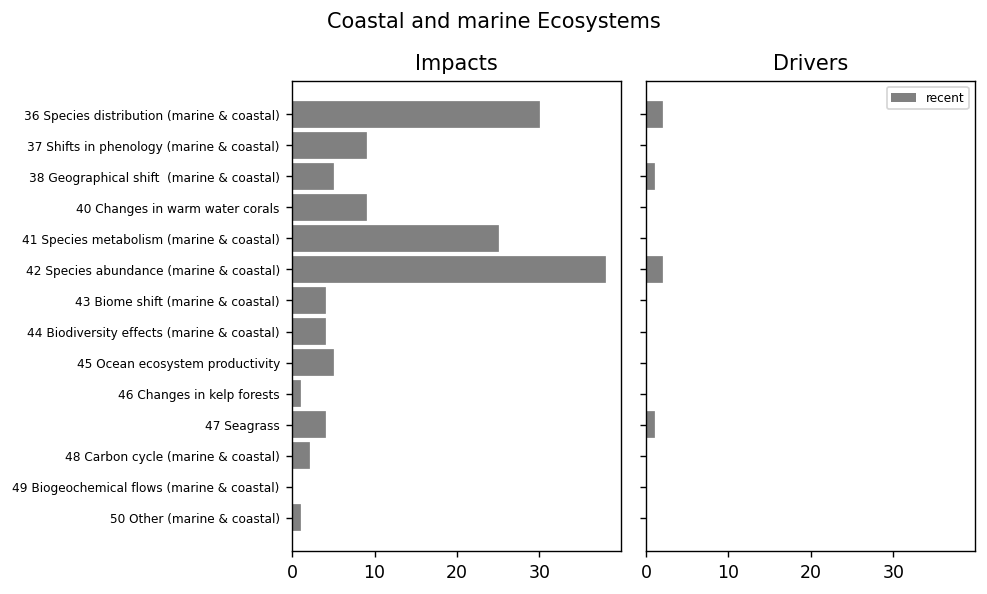

12 - Terrestrial ES
469.0
Terrestrial ES
[{'name': '59 Wildfires'}, {'name': '58 Pests and diseases'}, {'name': '51 Distribution and range shifts (Terrestrial and freshwater)'}, {'name': '54 Physiology and metabolism'}, {'name': '54 Physiology and metabolism'}, {'name': '52 Species abundance (Terrestrial and freshwater)<hidden>'}, {'name': '51 Distribution and range shifts (Terrestrial and freshwater)'}, {'name': '53 Mortality and growth'}, {'name': '53 Mortality and growth'}, {'name': '57 Biogeochemical flows (Terrestrial and freshwater)'}, {'name': '57 Biogeochemical flows (Terrestrial and freshwater)'}, {'name': '55 Community composition and interaction'}, {'name': '56 Terrestrial carbon cycle'}, {'name': '56 Terrestrial carbon cycle'}, {'name': '58 Pests and diseases'}, {'name': '48 Species distribution (Terrestrial and freshwater)<hidden>'}, {'name': '52 Shifts in phenology (Terrestrial and freshwater)'}, {'name': '58 Species metabolism (Terrestrial and freshwater)<hidden>'}, {'na

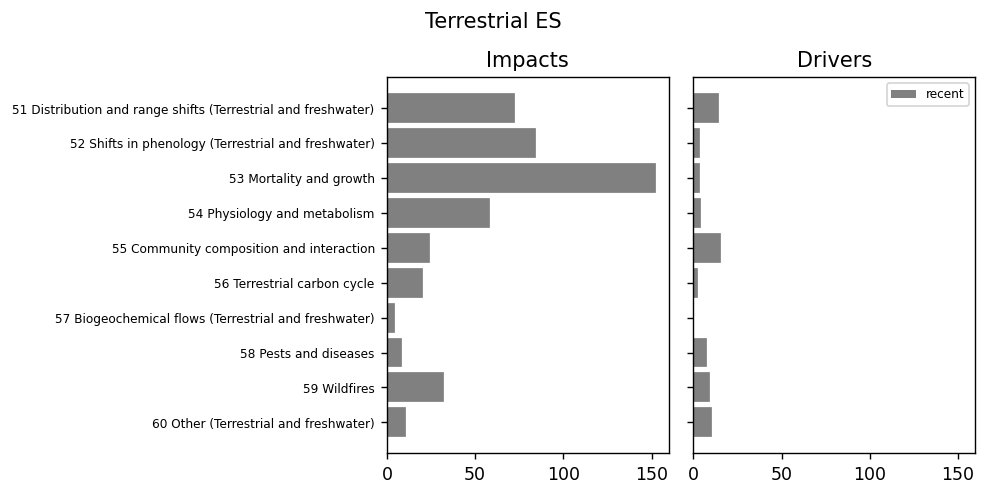

12 - Human and managed
303.0
Human and managed
[{'name': '71 Malnutrition'}, {'name': '68 Extreme heat exposure'}, {'name': '80 Livestock management'}, {'name': '80 Livestock management'}, {'name': '62 Coastal human systems'}, {'name': '68 Extreme heat exposure'}, {'name': '69 Crop yields'}, {'name': '78 Land management'}, {'name': '64 Indigenous communities'}, {'name': '75 Armed conflict<hidden>'}, {'name': '71 Malnutrition'}, {'name': '72 Conflict'}, {'name': '72 Conflict'}, {'name': '62 Coastal human systems'}, {'name': '73 Displacement and migration'}, {'name': '74 Economic inequality'}, {'name': '75 Economic activity'}, {'name': '70 Food prices'}, {'name': '65 Gender specific / gender unequal impacts'}, {'name': '66 Health'}, {'name': '67 Vector-borne diseases'}, {'name': '75 Armed conflict<hidden>'}, {'name': '76 Human water use'}, {'name': '76 Human water use'}, {'name': '78 Land management'}, {'name': '39 Changes in fisheries output/catch (potential)'}, {'name': '81 Other (huma

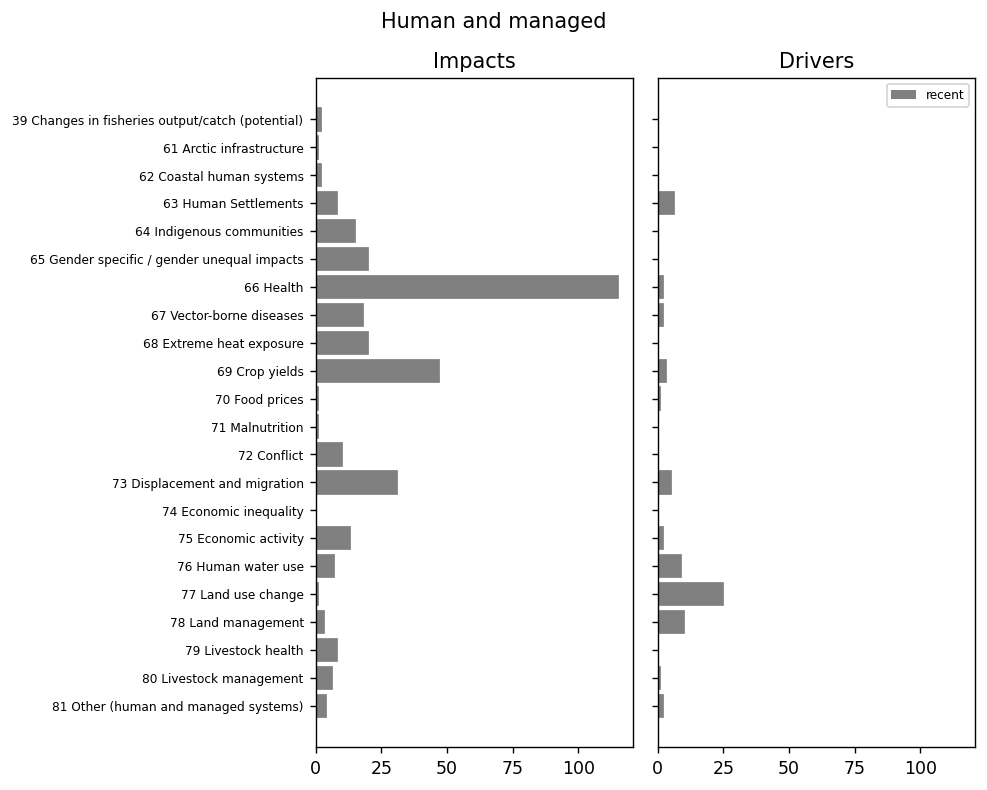

In [5]:

django.db.connection.close()
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
p = Project.objects.get(pk=178)
cats
classes = []


recent_tag_ids = list(Tag.objects.filter(query__project=p,id__gt=5361).values_list('doc__id',flat=True))

for c in cats:
    cname = f"{c.level} - {c.name}"
    print(cname)
    if cname in df.columns:
        pass
        print(df[cname].sum())
    else:
        df[cname] = 0
        print(0)
        
    fig, axs = plt.subplots(1,2,dpi=125,figsize=(8,2+0.2*c.equivalents.exclude(name__icontains='<hidden>').count()/2),sharey=True,sharex=True)
    ticks = []
    i = -1
    print(c)
    print(list(c.equivalents.values('name')))
    for ec in c.equivalents.all().order_by('-name','level'):
        ecname = f"{ec.level} - {ec.name}"

        
        if "<hidden>" not in ec.name:
            if ec.level==4:
                i+=1
                ticks.append(ec.name)
        
        if ecname in df.columns:
            if ec.level==4:
                df.loc[df[ecname]==1,cname] = 1  
            if "<hidden>" not in ec.name:
                if ec.level==4:
                    axs[0].barh(i, df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="none",edgecolor="grey",linewidth=1)
                    axs[0].barh(i, df.loc[df['id'].isin(recent_tag_ids),ecname].sum(),left=
                                df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="grey",edgecolor="grey",linewidth=1)
                else:
                    axs[1].barh(i, df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="none",edgecolor="grey",linewidth=1)
                    axs[1].barh(i, df.loc[df['id'].isin(recent_tag_ids),ecname].sum(),left=
                                df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="grey",edgecolor="grey",linewidth=1)
                
    if df[cname].sum()>0:
        if cname != "12 - Physical systems":
            classes.append(cname)
    print(df[cname].sum())
    
    axs[0].set_title("Impacts")
    axs[1].set_title("Drivers")
    
    axs[0].set_yticks(range(len(ticks)))
    axs[0].set_yticklabels(ticks,fontsize=7)
    
    axs[1].barh([0],[0],label="recent",color="grey")
    axs[1].legend(fontsize=7)
    
    plt.suptitle(c.name)
    fig.tight_layout()
    plt.subplots_adjust(top=0.81+0.002*c.equivalents.exclude(name__icontains='<hidden>').count())
    
    plt.savefig(f'../plots/progress/cats_labels_{c.name.replace(" ","_")}.pdf',bbox_inches="tight")
    
    plt.show()

In [6]:
broad_cats = [x for x in df.columns if "12 - " in x]
broad_cats
df['unlabelled'] = np.where(df[broad_cats].sum(axis=1)==0,1,0)

df[(df['unlabelled']==0) & (df['random_sample']==1)].shape

(123, 252)

In [7]:
broad_cats = [x for x in df.columns if "12 - " in x]
broad_cats
df['unlabelled'] = np.where(df[broad_cats].sum(axis=1)==0,1,0)

df[(df['unlabelled']==0) & ((df['random_sample']==1) | (df['representative_relevant_sample']==1))].shape

(305, 252)

In [8]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)
sub_df = df[(df['unlabelled']==0) & ((df['random_sample']==1) | (df['representative_relevant_sample']==1)) & df['relevant']==1]#.reset_index(drop=True)
for train, test in kf.split(sub_df.index):
    test = df[df.id.isin(sub_df.iloc[np.array(test),:].id)].index
    print(df[(df['12 - Mountains, snow and ice']==1) & (df.index.isin(test))].shape, len(test))
    print(test)

(14, 252) 88
Int64Index([  1,   6,  14,  20,  38,  48,  60,  67,  74,  83,  93,  95, 119,
            129, 137, 145, 164, 166, 190, 192, 206, 237, 260, 267, 270, 271,
            275, 288, 294, 297, 298, 303, 320, 329, 348, 361, 363, 377, 378,
            381, 394, 405, 416, 421, 427, 444, 445, 472, 477, 511, 522, 526,
            544, 555, 559, 567, 569, 571, 577, 585, 593, 615, 635, 648, 652,
            656, 690, 698, 707, 715, 758, 769, 778, 806, 811, 814, 844, 849,
            856, 878, 900, 934, 936, 950, 964, 965, 970, 980],
           dtype='int64')
(16, 252) 87
Int64Index([ 989,  995, 1003, 1005, 1015, 1016, 1023, 1027, 1062, 1068, 1087,
            1095, 1096, 1102, 1109, 1111, 1118, 1142, 1148, 1154, 1170, 1176,
            1191, 1205, 1227, 1233, 1239, 1242, 1248, 1256, 1279, 1290, 1308,
            1339, 1345, 1365, 1388, 1397, 1400, 1401, 1406, 1412, 1413, 1416,
            1420, 1441, 1453, 1461, 1476, 1504, 1513, 1519, 1521, 1523, 1526,
            1532, 1569, 1577, 157

In [9]:
all_impacts = [x for x in df.columns if re.match("^4 -",x)]


df['6 - Precipitation'] = 0
df.loc[
    (df['6 - 05 Changes in precipitation']==1) | 
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 06 Humidity']==1) |
    (df['6 - 08 Changes in strong precipitation']==1),
    "6 - Precipitation"] = 1

# Class precip impacts as drivers
df.loc[
    (df['6 - 05 Changes in precipitation']==1) | 
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 06 Humidity']==1) |
    (df['6 - 08 Changes in strong precipitation']==1),
    "6 - Precipitation"] = 1


df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) |
    (df['6 - 16 Sea surface temperature']==1) |
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1
# Class temp impacts as drivers
df.loc[
    (df['4 - 03 Extreme temperature']==1) |
    (df['4 - 16 Sea surface temperature']==1) |
    (df['4 - 02 Air or land surface temperature changes']==1) |
    (df['4 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['driver_coded'] = np.where(df[all_impacts].sum(axis=1)==0,0,1)

df['6 - Other'] = 0
df.loc[
    (df['6 - Temperature']==0) & 
    (df['6 - Precipitation']==0),
    '6 - Other'
] = 1


In [10]:
keep_columns = [x for x in df.columns 
                if "10 -" not in x and "11 - " not in x and "13 - " not in x and "14 - " not in x and "15 -" not in x
                and "16 - " not in x and "7 - " not in x and "8 - " not in x and "3 - " not in x
               ]
print(df[keep_columns].shape)
list(df[keep_columns].columns)

(2630, 182)


['id',
 'content',
 'title',
 'wosarticle__de',
 'wosarticle__wc',
 'ar5',
 'seen',
 'relevant',
 'random_sample',
 'representative_relevant_sample',
 'physical_tags',
 '12 - Coastal and marine Ecosystems',
 '12 - Human and managed',
 '12 - Mountains, snow and ice',
 '12 - Rivers, lakes, and soil moisture',
 '12 - Terrestrial ES',
 '2 - 2.1. Climate change attribution',
 '2 - 2.2 Trend attribution',
 '2 - 2.3. Attribution to extreme event',
 '2 - 2.3. Impact trend attribution<hidden>',
 '2 - 2.4. Sensitivity',
 '2 - 2.5. Detection of a regional climate trend (no attribution)',
 '2 - 2.6. Null results',
 '4 - 01 CO2 concentration',
 '4 - 02 Air or land surface temperature changes',
 '4 - 03 Extreme temperature',
 '4 - 04 Radiation',
 '4 - 05 Changes in precipitation',
 '4 - 06 Humidity',
 '4 - 07 Aridity/dryness',
 '4 - 08 Changes in strong precipitation',
 '4 - 09 Atmospheric/marine circulation or teleconnections',
 '4 - 10 Wind speed',
 '4 - 11 Storms',
 '4 - 12 Seasonality',
 '4 - 13

In [11]:
import datetime
print(datetime.datetime.now())
df.to_csv('../data/0_labelled_documents.csv',index=False)



2021-04-07 17:58:18.038318


In [12]:
list(df.columns)

['id',
 'content',
 'title',
 'wosarticle__de',
 'wosarticle__wc',
 'ar5',
 'seen',
 'relevant',
 'random_sample',
 'representative_relevant_sample',
 'physical_tags',
 '12 - Coastal and marine Ecosystems',
 '12 - Human and managed',
 '12 - Mountains, snow and ice',
 '12 - Rivers, lakes, and soil moisture',
 '12 - Terrestrial ES',
 '10 - places',
 '11 - Africa',
 '11 - Asia',
 '11 - Australasia',
 '11 - Central & South America',
 '11 - Europe',
 '11 - Global',
 '11 - North America',
 '11 - Open ocean',
 '11 - Polar Regions',
 '11 - Small Islands',
 '13 - Coastal erosion and/or sea level effects',
 '13 - Food production',
 '13 - Glaciers, snow, ice and/or permafrost',
 '13 - Livelihoods, health and/or economics',
 '13 - Marine ecosystems',
 '13 - Rivers, lakes, floods and/or drought',
 '13 - Terrestrial ecosystems',
 '13 - Wildfire',
 '14 - Coastal human systems',
 '14 - Cryosphere',
 '14 - Droughts',
 '14 - Marine (eco-)systems',
 '14 - River floods',
 '14 - Terrestrial (eco-)systems',